# Transitioning between images in latent space (lat dim = 800)

In [18]:
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.utils import image_dataset_from_directory

In [19]:
#Define parameters
INPUT_SHAPE = (448, 448, 3)
EPOCHS = 4000
LATENT_DIMS = 800

In [39]:
ds = image_dataset_from_directory('/home/jupyter/data_local', label_mode=None, image_size=(448, 448), batch_size=16)

Found 2360 files belonging to 1 classes.


In [40]:
imgs = ds.as_numpy_iterator().__next__()

In [41]:
imgs.shape

(16, 448, 448, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


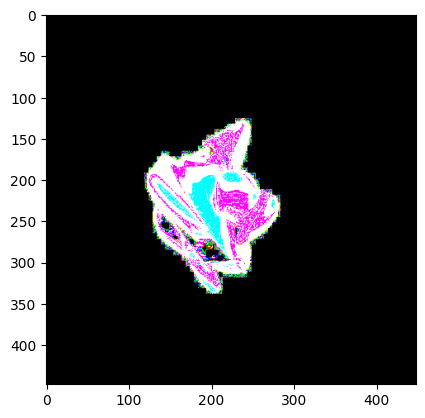

In [43]:
plt.imshow(imgs[0])

In [44]:
X_train = imgs/255

In [45]:
def build_encoder(latent_dimension):
    encoder = Sequential()
    
    encoder.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(448, 448, 3)))
    encoder.add(BatchNormalization())
    encoder.add(MaxPooling2D((2, 2)))

    encoder.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    encoder.add(BatchNormalization())
    encoder.add(MaxPooling2D((2, 2)))

    encoder.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    encoder.add(BatchNormalization())
    encoder.add(MaxPooling2D((2, 2)))
    
    encoder.add(Conv2D(256, (3, 3), padding='same', activation=LeakyReLU()))
    encoder.add(BatchNormalization())
    encoder.add(MaxPooling2D((2, 2)))

    encoder.add(Flatten())
    encoder.add(Dense(latent_dimension, activation='tanh'))
    
    return encoder



In [46]:
from tensorflow.keras.layers import Reshape, Conv2DTranspose, UpSampling2D
def build_decoder(latent_dimension):
    decoder = Sequential()
    decoder.add(Dense(7*7*64, activation='tanh', input_shape=(latent_dimension,)))
    decoder.add(Reshape((7, 7, 64)))
    decoder.add(Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu'))
    #decoder.add(UpSampling2D((2, 2)))
    decoder.add(Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu'))
    decoder.add(Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu'))
    decoder.add(Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation='relu'))
    decoder.add(Conv2DTranspose(8, (3, 3), strides=2, padding='same', activation='relu'))
    decoder.add(Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='sigmoid'))
    return decoder

In [47]:
encoder = build_encoder(LATENT_DIMS)


In [48]:
decoder = build_decoder(LATENT_DIMS)

In [49]:
encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 448, 448, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 448, 448, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 224, 224, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 224, 224, 64)      18496     
                                                                 
 batch_normalization_5 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                      

In [50]:
decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 3136)              2511936   
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 14, 14, 128)      73856     
 ranspose)                                                       
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 28, 28, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 56, 56, 32)       18464     
 ranspose)                                                       
                                                      

In [51]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
def build_autoencoder(encoder, decoder):
    inp = Input((448, 448, 3))
    encoded = encoder(inp)
    decoded = decoder(encoded)
    autoencoder = Model(inp, decoded)
    return autoencoder

autoencoder = build_autoencoder(encoder, decoder)

In [52]:
def compile_autoencoder(autoencoder):
    autoencoder.compile(loss='mse', optimizer='adam')

In [53]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='loss', patience=50, restore_best_weights=True)

compile_autoencoder(autoencoder)
autoencoder.fit(X_train, X_train, epochs=1000, batch_size=32, callbacks=[es], verbose=1)


Epoch 1/1000


2023-03-10 10:59:17.595501: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


1/1 [==============================] - 6s 6s/step - loss: 0.2283
Epoch 2/1000
1/1 [==============================] - 1s 687ms/step - loss: 0.2280
Epoch 3/1000
1/1 [==============================] - 1s 688ms/step - loss: 0.2278
Epoch 4/1000
1/1 [==============================] - 1s 680ms/step - loss: 0.2275
Epoch 5/1000
1/1 [==============================] - 1s 687ms/step - loss: 0.2272
Epoch 6/1000
1/1 [==============================] - 1s 679ms/step - loss: 0.2269
Epoch 7/1000
1/1 [==============================] - 1s 678ms/step - loss: 0.2266
Epoch 8/1000
1/1 [==============================] - 1s 676ms/step - loss: 0.2262
Epoch 9/1000
1/1 [==============================] - 1s 675ms/step - loss: 0.2259
Epoch 10/1000
1/1 [==============================] - 1s 679ms/step - loss: 0.2255
Epoch 11/1000
1/1 [==============================] - 1s 678ms/step - loss: 0.2251
Epoch 12/1000
1/1 [==============================] - 1s 678ms/step - loss: 0.2246
Epoch 13/1000
1/1 [======================

In [56]:
prediction = autoencoder.predict(X_train, verbose=0, batch_size=32)# you can now display an image to see it is reconstructed well
    

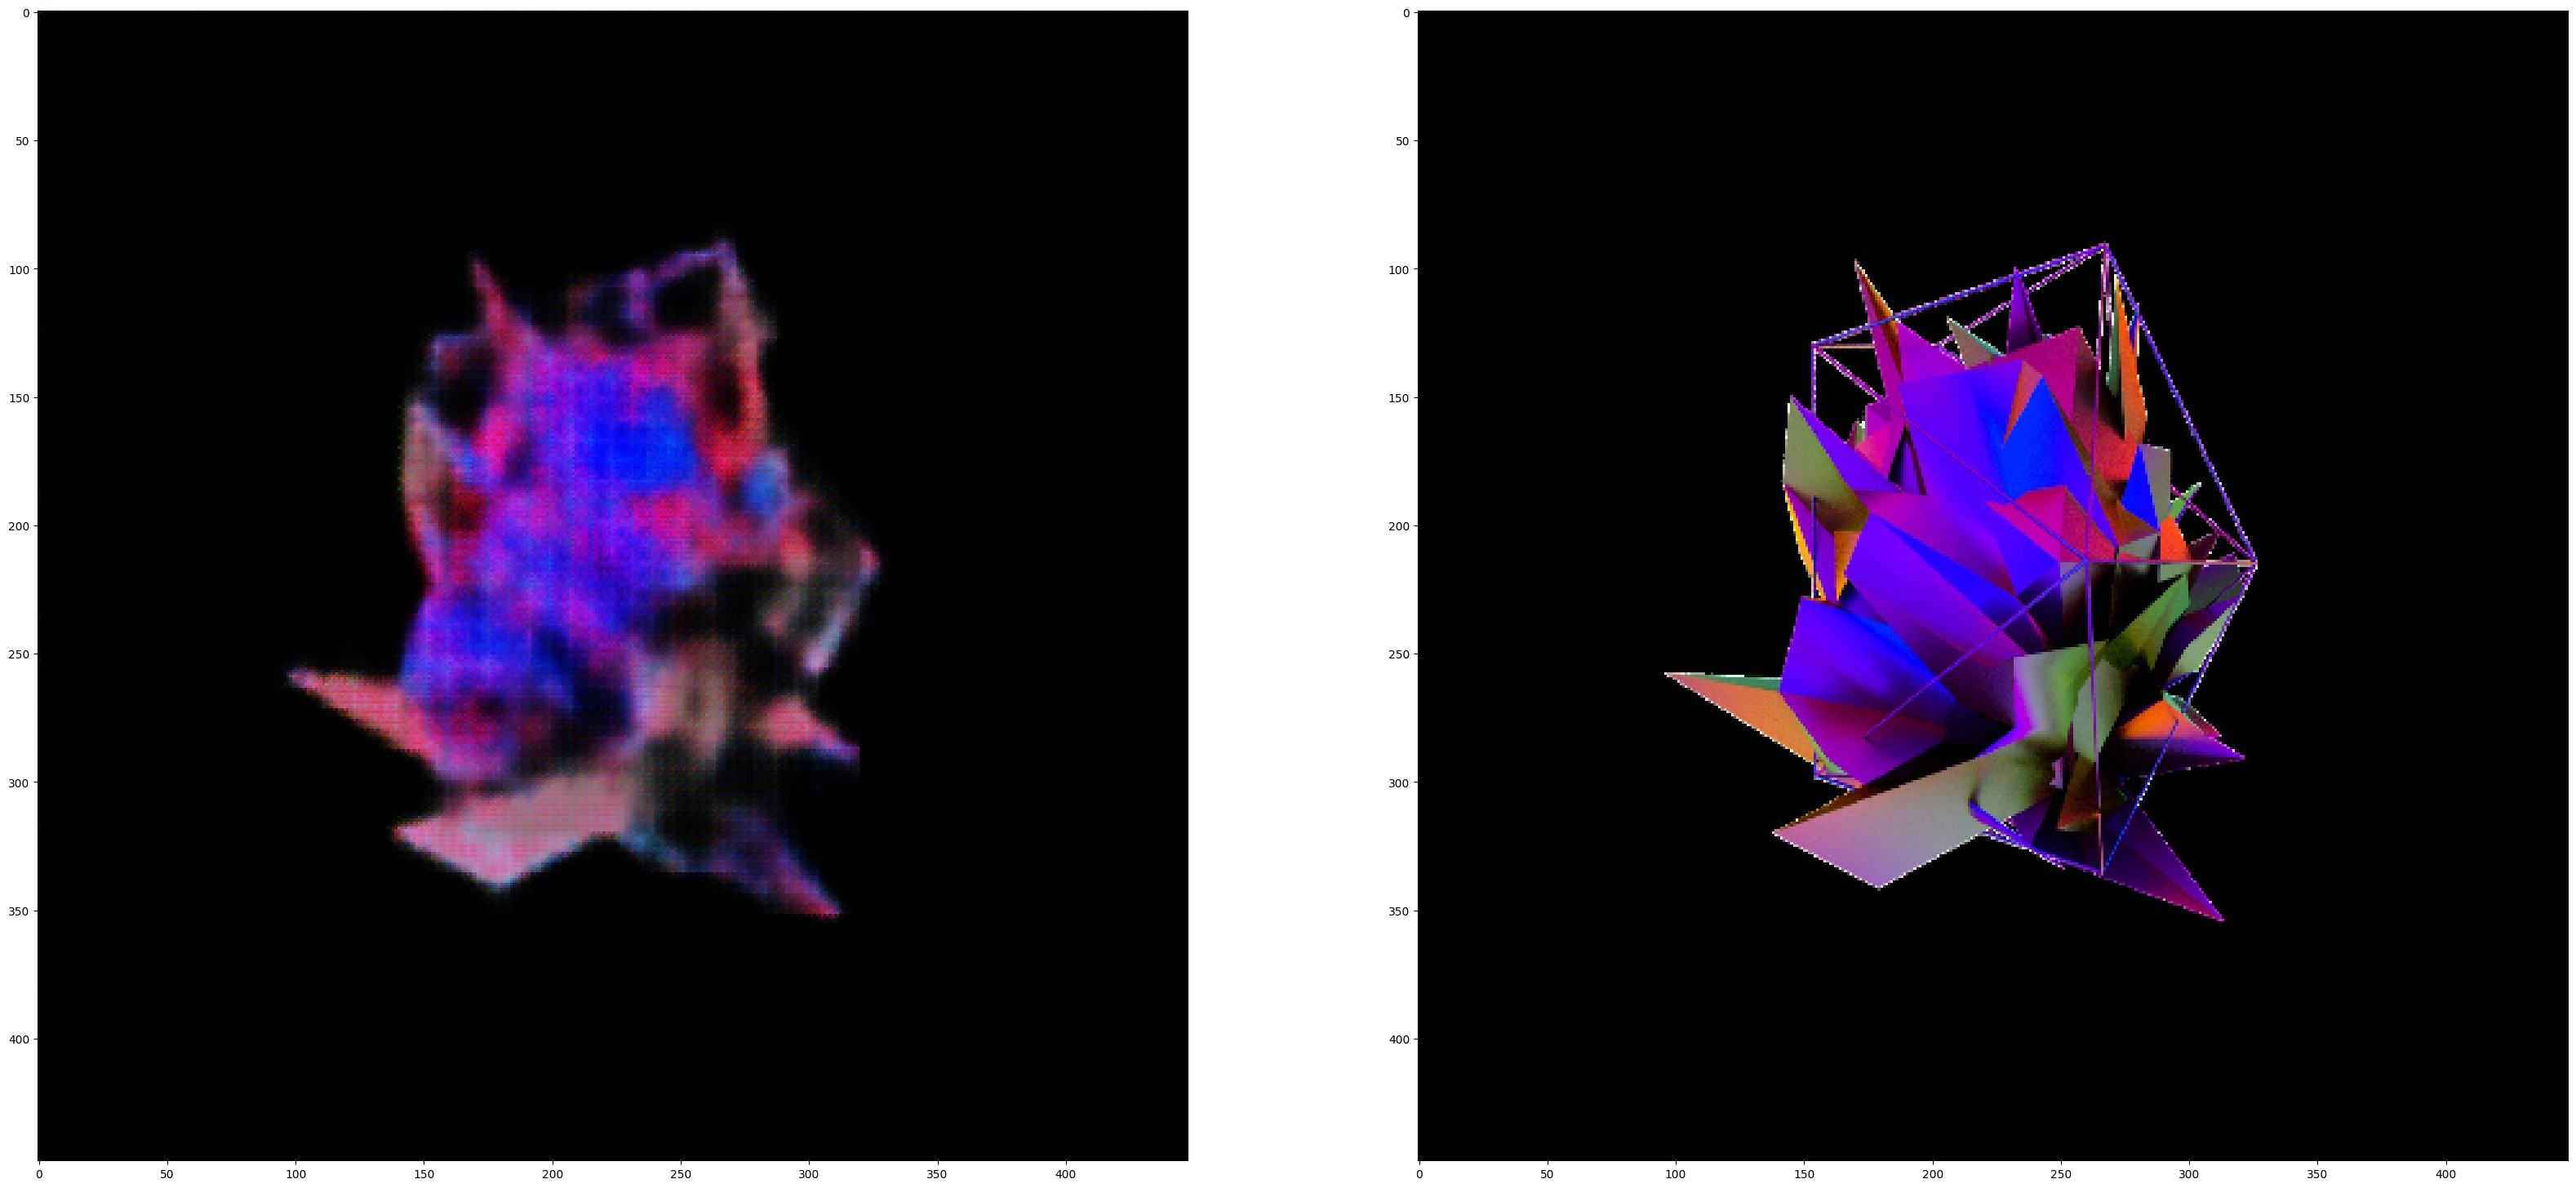

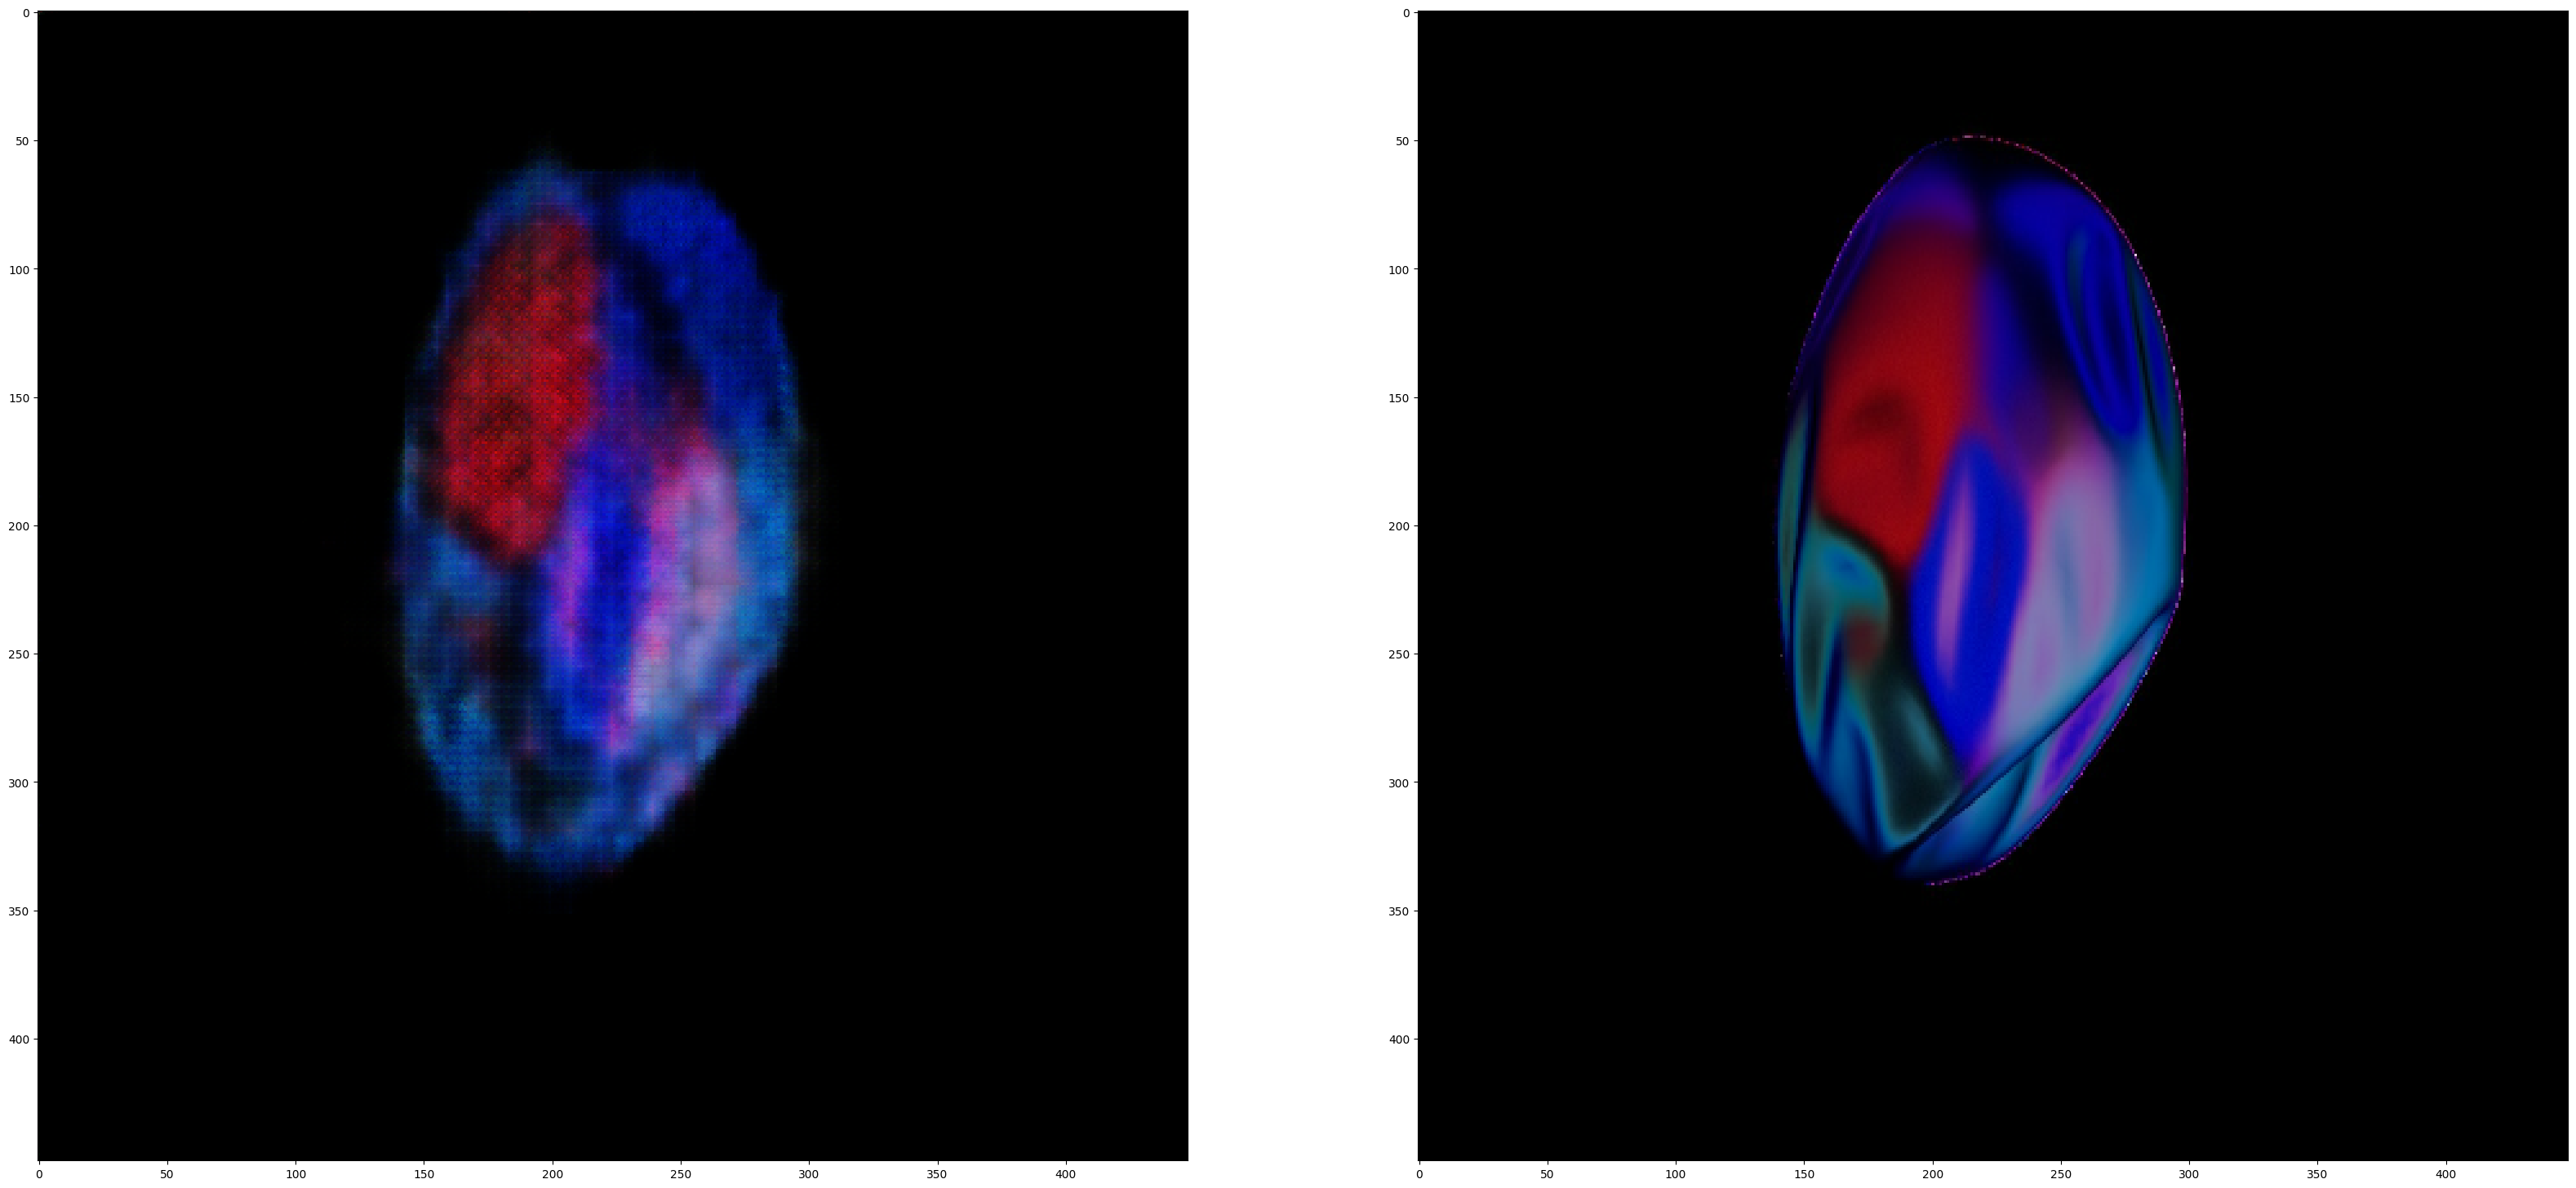

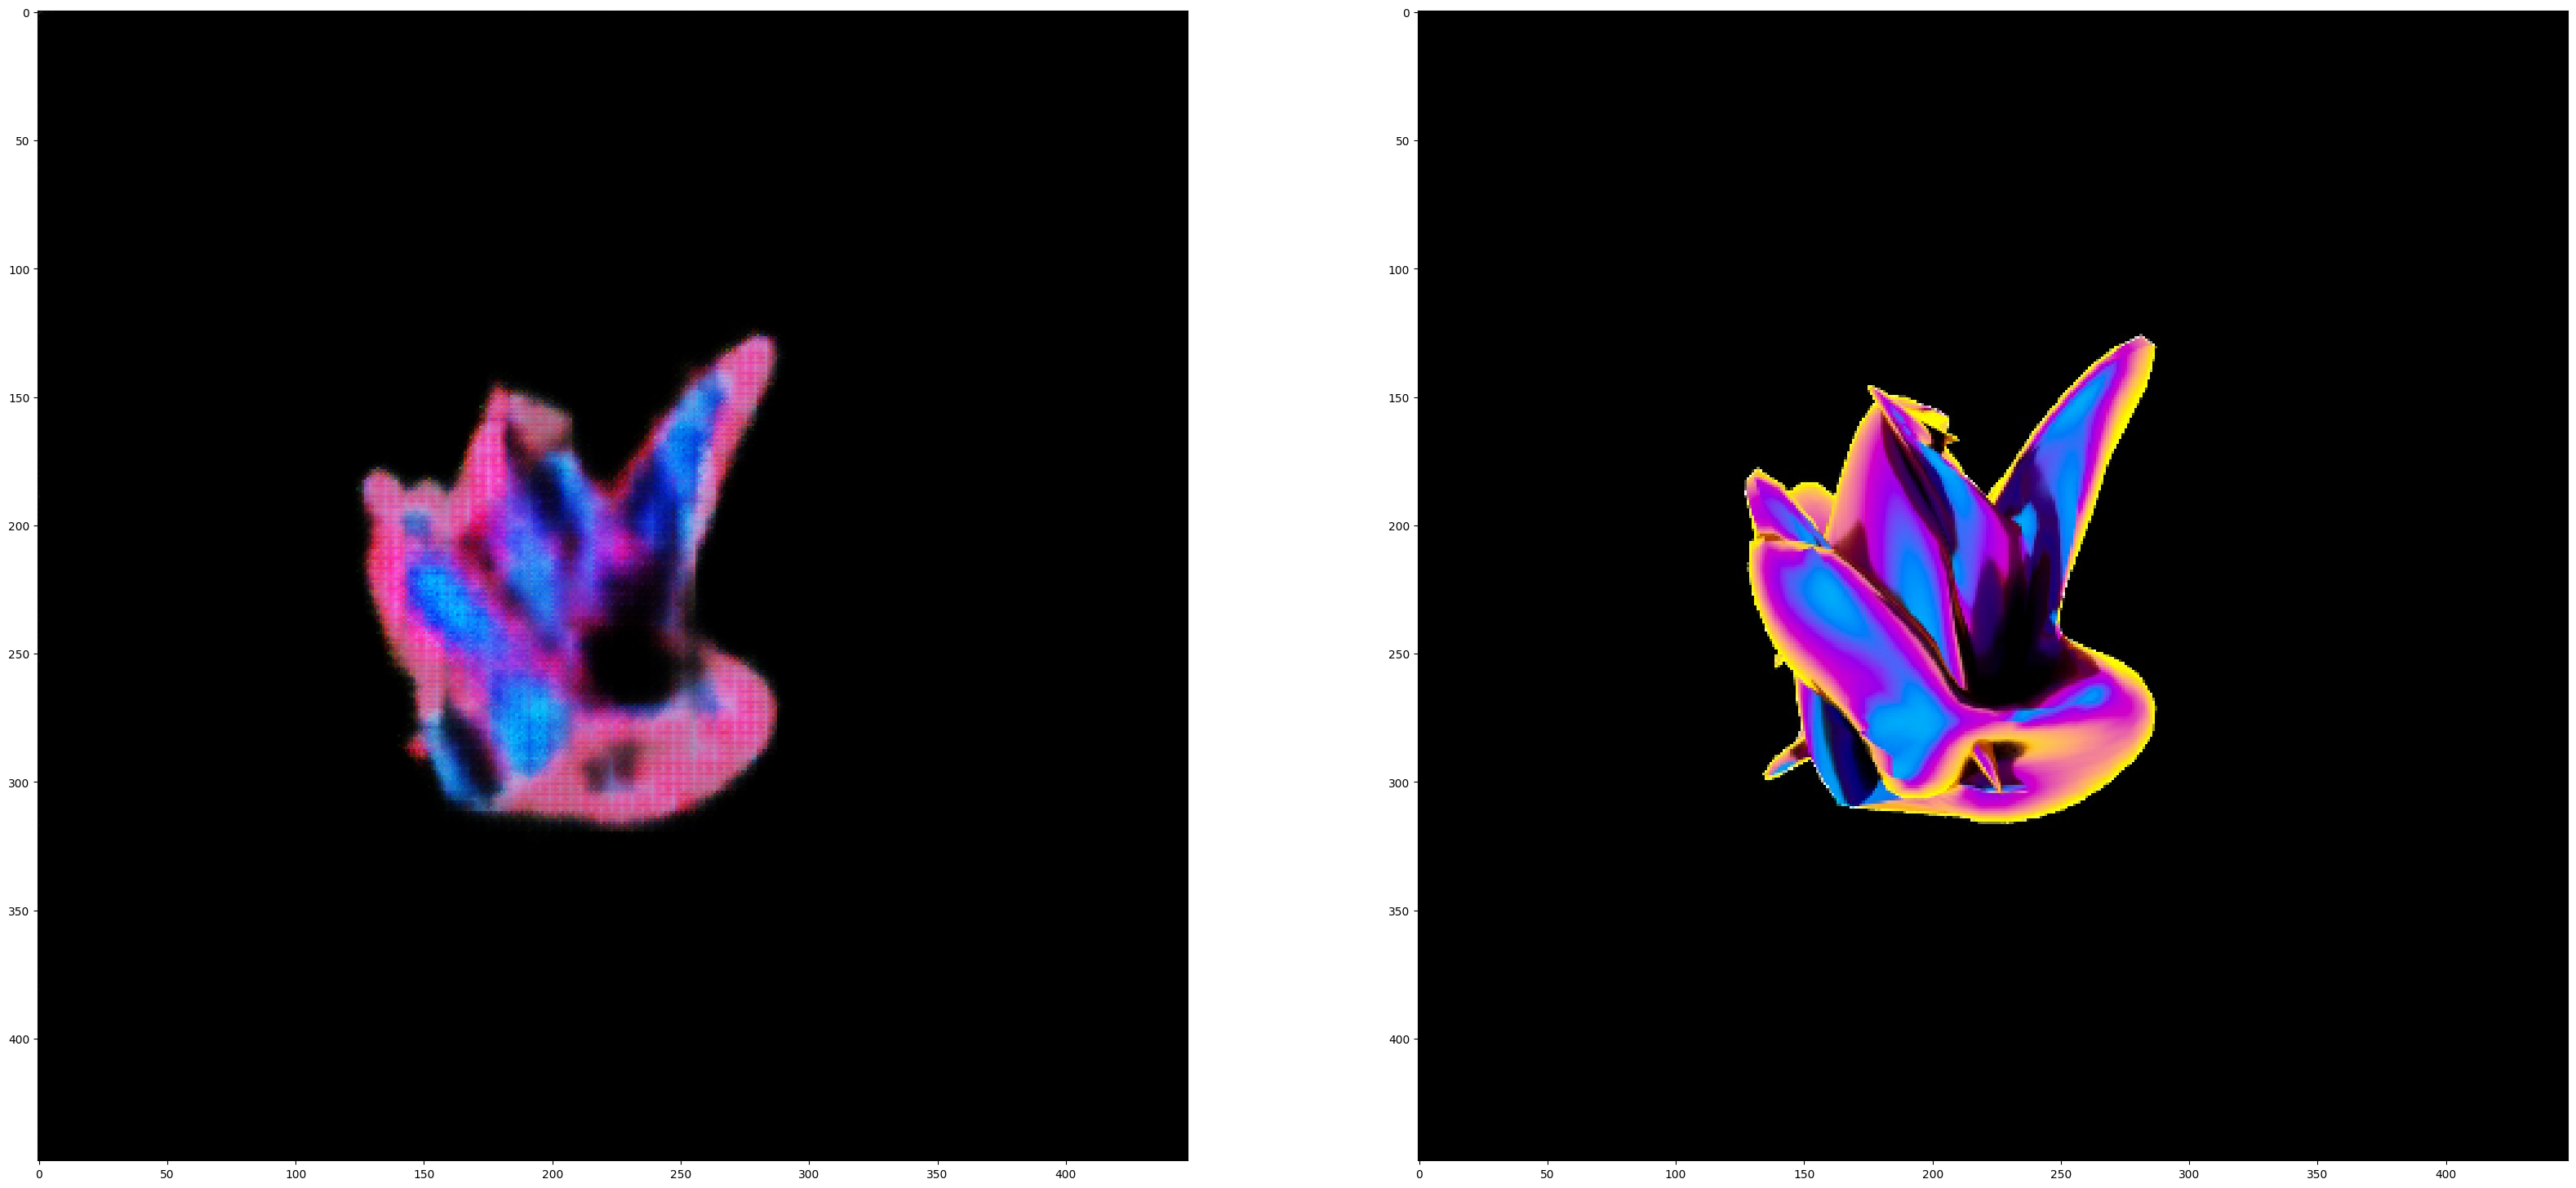

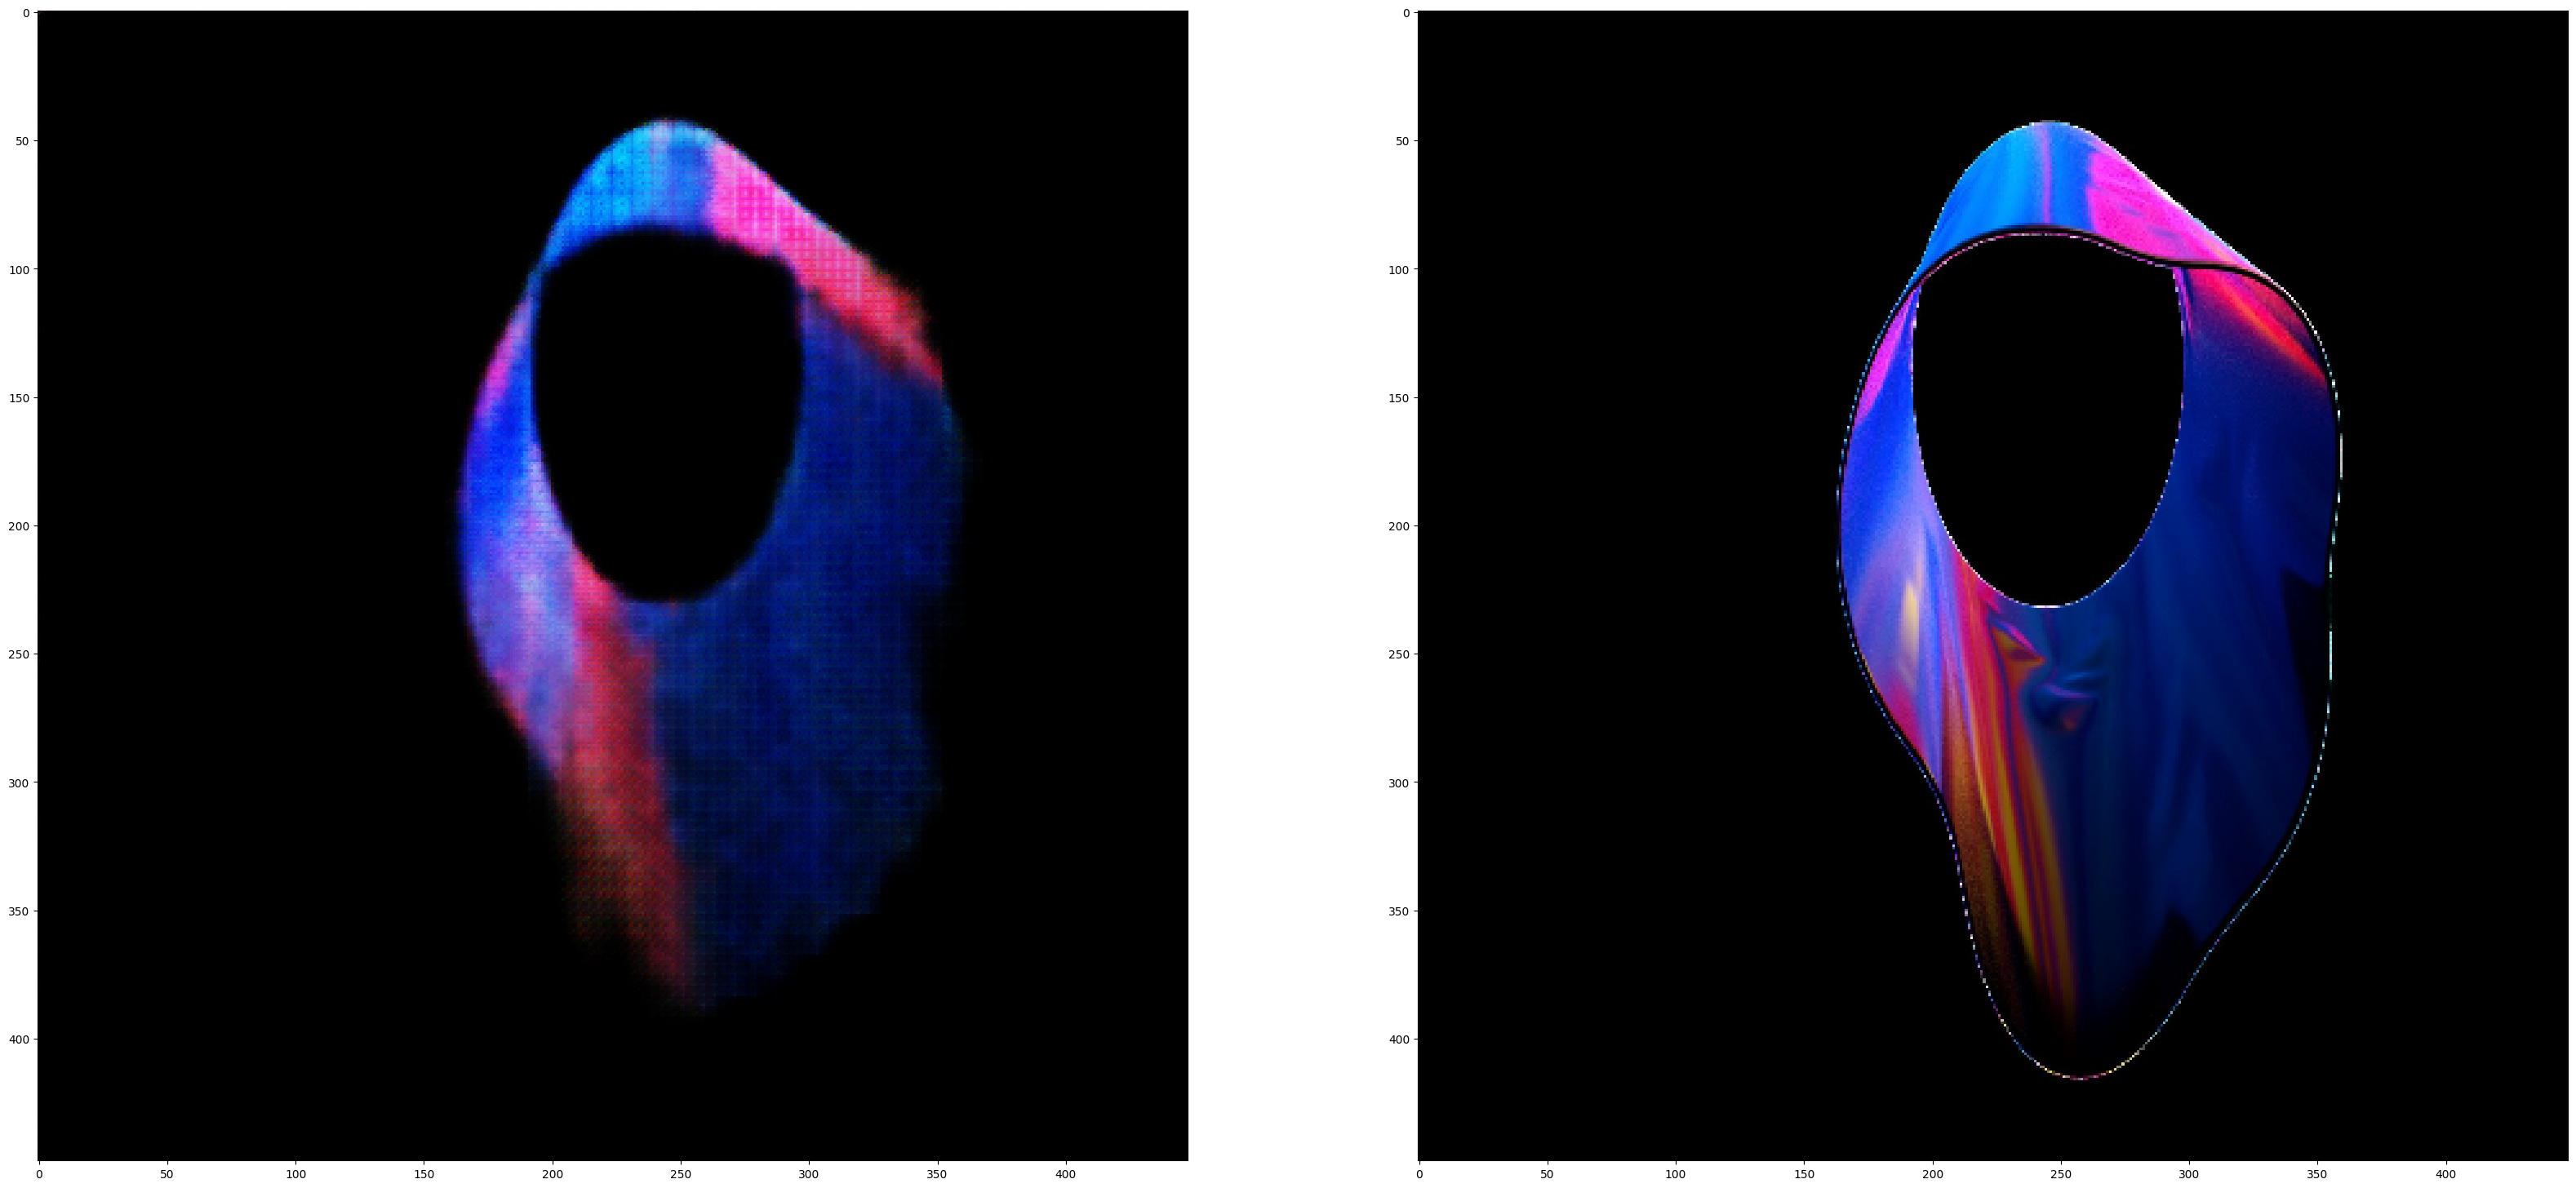

In [57]:
for i in range(3,7):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))
    ax1.imshow((prediction[i] * 255).astype(np.uint8))
    ax2.imshow(X_train[i].reshape(448, 448, 3))
    plt.show()

In [ ]:
#autoencoder.save('autoencoder-latent-dim-800.h5')

In [58]:
encoded_pred = encoder.predict(X_train[3:5])

In [59]:
start_lat_vec, end_lat_vec = encoded_pred[0], encoded_pred[1]


In [60]:
start_lat_vec.shape, end_lat_vec.shape


((800,), (800,))

In [61]:
N_STEPS = 100

step_vec = (end_lat_vec - start_lat_vec ) / N_STEPS

In [62]:
interpolation_images = []

for i in range(0, N_STEPS):
    interpolation_images.append(start_lat_vec + (i * step_vec))
    
interp_array = np.array(interpolation_images)

In [63]:
interp_array.shape

(100, 800)

In [64]:
inter_images = decoder.predict(interp_array)
inter_images = (inter_images * 255).astype('uint8')


In [65]:
inter_images.shape

(100, 448, 448, 3)

In [71]:
for i in range(inter_images.shape[0]):
    im = Image.fromarray(inter_images[i])
    im.save(f'/home/jupyter/image_{i}.jpg')


In [72]:
!pwd

/home/jupyter


In [77]:
def make_gif(frame_folder):
    im_paths = [f'{frame_folder}/image_{i}.jpg' for i in range(100)]
    frames = [Image.open(image) for image in im_paths]
    
    frame_one = frames[0]
    frame_one.save(
        'sb-gif-test.gif', 
        format='GIF', 
        append_images=frames, 
        save_all=True,
        duration=100,
        loop=0
    )

In [78]:
make_gif('/home/jupyter/')